# Plant Disease Classifier

This model making script will build up a machine learning model which can classify picture of any plant disease into several one specific label from labels.

# Imports

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score , auc
from sklearn.model_selection import train_test_split
import tensorflow_decision_forests as tfdf

import cv2
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Input, Dense,Conv2D , MaxPooling2D, Flatten, BatchNormalization, Dropout
from keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
import tensorflow_hub as hub

NotFoundError: c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow_decision_forests\tensorflow\ops\inference\inference.so not found

In [ ]:
class HubLayer(tf.keras.layers.Layer):
    def __init__(self, handle, **kwargs):
        self.handle = handle
        super(HubLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.hub_layer = hub.KerasLayer(self.handle, trainable=False)
        super(HubLayer, self).build(input_shape)

    def call(self, inputs, **kwargs):
        return self.hub_layer(inputs)

    def get_config(self):
        config = super(HubLayer, self).get_config()
        config.update({"handle": self.handle})
        return config

# Replace 'path/to/your/model.h5' with the actual path to your HDF5 model file
model_path = '/content/drive/MyDrive/skripsiThings/Model/plantmodeltype2.h5'

# Define a custom object scope to tell TensorFlow about the custom layer
custom_objects = {'HubLayer': HubLayer}

# Load the model using the custom object scope
with tf.keras.utils.custom_object_scope(custom_objects):
    model = tf.keras.models.load_model(model_path)

# Save as TensorFlow SavedModel
#tf.saved_model.save(model, "saved_model")

# Convert SavedModel to ONNX
#onnx_model = tf2onnx.convert.from_keras(model, output_path="/content/drive/MyDrive/skripsiThings/plantmodeltype2.onnx")

In [2]:
train_path = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train"
test_path = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid"

# Data Augmentation

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

generator_train = ImageDataGenerator(rescale = 1.0/255.0,
                                     rotation_range = 40,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     featurewise_center=False,
                                     samplewise_center=False,
                                     featurewise_std_normalization=False,
                                     samplewise_std_normalization=False,
                                     zca_whitening=False,
                                     horizontal_flip=True,
                                     vertical_flip=False)

generator_test = ImageDataGenerator(rescale=1./255,
                                    featurewise_center=False,
                                    samplewise_center=False,
                                    featurewise_std_normalization=False,
                                    samplewise_std_normalization=False,
                                    zca_whitening=False,
                                    rotation_range=40,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=False)

train_generator = generator_train.flow_from_directory(
    train_path,
    class_mode='categorical',
    target_size=[128, 128],
    color_mode="rgb",
    batch_size=64,
)
test_generator = generator_test.flow_from_directory(
    test_path,
    class_mode='categorical',
    target_size=[128, 128],
    color_mode="rgb",
    batch_size=64,
)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


# Transfer Learning

In [4]:
class HubLayer(tf.keras.layers.Layer):
    def __init__(self, handle, **kwargs):
        self.handle = handle
        super(HubLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.hub_layer = hub.KerasLayer(self.handle, trainable=False)
        super(HubLayer, self).build(input_shape)

    def call(self, inputs, **kwargs):
        return self.hub_layer(inputs)

    def get_config(self):
        config = super(HubLayer, self).get_config()
        config.update({"handle": self.handle})
        return config

In [5]:
MODULE_HANDLE = "/kaggle/input/mobilenet-v2/tensorflow2/035-128-classification/2"
module = HubLayer(MODULE_HANDLE, input_shape=(128,128,3), trainable=False)

In [6]:
num_classes = 38

#MODEL 1
#model = tf.keras.models.Sequential([
#    module,
#    tf.keras.layers.Dense(512, activation='relu'),
#    tf.keras.layers.Dense(256, activation='relu'),
#    tf.keras.layers.Dense(num_classes, activation='softmax')
#])

#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#model.summary()

#MODEL 2
model = tf.keras.models.Sequential([
    module,
    tf.keras.layers.Dense(1024, activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.Dense(num_classes, activation='sigmoid')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

#MODEL 3
#model = Sequential()
#model.add(Rescaling(1./255 ,input_shape=(224,224,3)))
#model.add(Conv2D(16, 3, padding='same', activation='relu'))
#model.add(MaxPooling2D())
#model.add(Conv2D(32, 3, padding='same', activation='relu'))
#model.add(MaxPooling2D())
#model.add(Conv2D(64, 3, padding='same', activation='relu'))
#model.add(MaxPooling2D())
#model.add(Dropout(0.2))
#model.add(Flatten())
#model.add(Dense(128, activation='relu'))
#model.add(Dense(num_classes, activation = 'softmax'))
#model.summary()

#model.compile(loss='categorical_crossentropy',optimizer='adam' , metrics=['accuracy'])

#model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_layer (HubLayer)        (None, 1001)              1692489   
                                                                 
 dense (Dense)               (None, 1024)              1026048   
                                                                 
 dense_1 (Dense)             (None, 38)                38950     
                                                                 
Total params: 2757487 (10.52 MB)
Trainable params: 1064998 (4.06 MB)
Non-trainable params: 1692489 (6.46 MB)
_________________________________________________________________


# Training Model

In [7]:
from tensorflow.keras.callbacks import Callback

class ConvergenceChecker(Callback):
    def __init__(self, threshold=0.01):
        super(ConvergenceChecker, self).__init__()
        self.threshold = threshold
        self.prev_loss = None

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get('loss')

        if self.prev_loss is not None:
            loss_difference = abs(current_loss - self.prev_loss)

            if loss_difference < self.threshold:
                print(f"\nModel has converged. Stopping training at epoch {epoch + 1}.")
                self.model.stop_training = True

        self.prev_loss = current_loss

In [8]:
callback = ConvergenceChecker(0.001)

#HIST 1
# history = model.fit(train_generator,
#                     epochs = 34,
#                     steps_per_epoch = 172,
#                     validation_data = test_generator,
#                     validation_steps = 33,
#                     callbacks=[callback])

#HIST 2
#hist = model.fit(train_generator,validation_data=test_generator,epochs=50,callbacks=[callback])

#HIST 3
hist = model.fit(train_generator,
                 epochs=20,
                 steps_per_epoch = 1098,
                 validation_data=test_generator,
                 validation_steps = 274,
                 callbacks=[callback])

Epoch 1/20
1098/1098 [==============================] - 967s 877ms/step - loss: 0.5756 - accuracy: 0.8179 - val_loss: 0.4376 - val_accuracy: 0.8557
Epoch 2/20
1098/1098 [==============================] - 718s 654ms/step - loss: 0.3736 - accuracy: 0.8767 - val_loss: 0.3714 - val_accuracy: 0.8810
Epoch 3/20
1098/1098 [==============================] - 689s 627ms/step - loss: 0.3411 - accuracy: 0.8885 - val_loss: 0.3320 - val_accuracy: 0.8926
Epoch 4/20
1098/1098 [==============================] - 738s 672ms/step - loss: 0.3195 - accuracy: 0.8954 - val_loss: 0.3407 - val_accuracy: 0.8935
Epoch 5/20
1098/1098 [==============================] - 722s 658ms/step - loss: 0.3014 - accuracy: 0.9022 - val_loss: 0.3357 - val_accuracy: 0.8914
Epoch 6/20
1098/1098 [==============================] - 792s 721ms/step - loss: 0.2897 - accuracy: 0.9057 - val_loss: 0.3157 - val_accuracy: 0.8996
Epoch 7/20
1098/1098 [==============================] - 736s 670ms/step - loss: 0.2801 - accuracy: 0.9091 - val_

# Plotting the Result

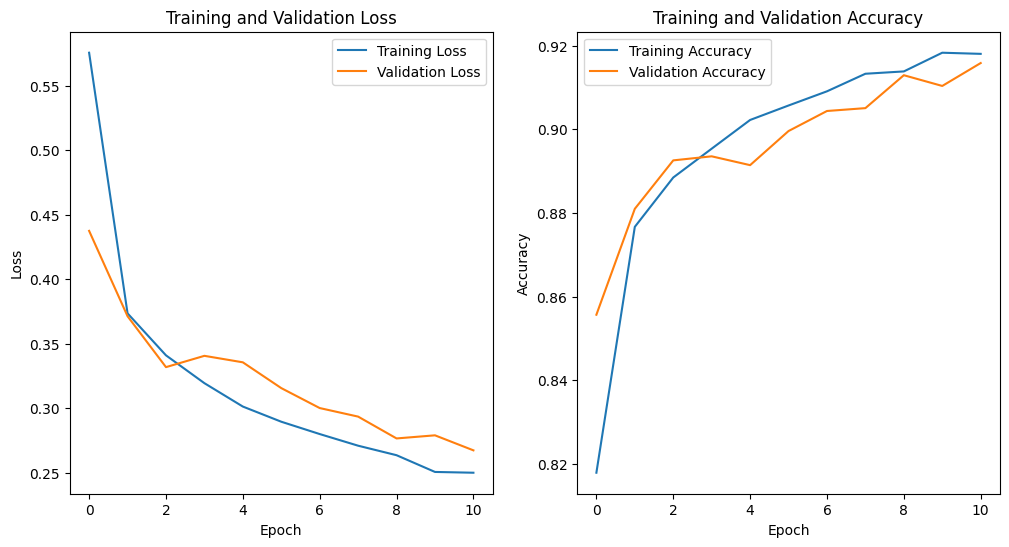

In [9]:
# Extract training and validation loss values
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

# Extract training and validation accuracy values
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Saving Model

In [ ]:
model.save('/kaggle/output/plantmodeltype2.h5')
model.save_weights('/kaggle/output/plantmodeltype2weights.h5')

In [11]:
model.save('/kaggle/working/plantmodeltype2.h5')
model.save_weights('/kaggle/working/plantmodeltype2weights.h5')

# Testing Prediction

In [12]:
class HubLayer(tf.keras.layers.Layer):
    def __init__(self, handle, **kwargs):
        self.handle = handle
        super(HubLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.hub_layer = hub.KerasLayer(self.handle, trainable=False)
        super(HubLayer, self).build(input_shape)

    def call(self, inputs, **kwargs):
        return self.hub_layer(inputs)

    def get_config(self):
        config = super(HubLayer, self).get_config()
        config.update({"handle": self.handle})
        return config

# Replace 'path/to/your/model.h5' with the actual path to your HDF5 model file
model_path = '/kaggle/output/plantmodeltype2.h5'

# Define a custom object scope to tell TensorFlow about the custom layer
custom_objects = {'HubLayer': HubLayer}

# Load the model using the custom object scope
with tf.keras.utils.custom_object_scope(custom_objects):
    model = tf.keras.models.load_model(model_path)

# Display the loaded model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_layer (HubLayer)        (None, 1001)              1692489   
                                                                 
 dense (Dense)               (None, 1024)              1026048   
                                                                 
 dense_1 (Dense)             (None, 38)                38950     
                                                                 
Total params: 2757487 (10.52 MB)
Trainable params: 1064998 (4.06 MB)
Non-trainable params: 1692489 (6.46 MB)
_________________________________________________________________


In [13]:
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
def prepare_data_for_prediction(src):
  img = load_img(src, target_size=(128,128))
  img_array = img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array = preprocess_input(img_array)
  return img_array

label_array = ['scab', 'black rot', 'cedar rust', 'healthy', 'healthy', 'healthy', 'powder mildew', 'spot grey leaf', 'common rust', 'healthy', 'leaf blight', 'black rot', 'black measles', 'healthy', 'leaf blight', 'citrus greening', 'bacterial spot', 'healthy', 'bacterial spot', 'healthy', 'early blight', 'healthy', 'late blight', 'healthy', 'healthy', 'powder mildew', 'healthy', 'leaf scorch', 'bacterial spot', 'early blight', 'healthy', 'late blight', 'leaf mold', 'septoria leaf spot', 'two spotted spider mite', 'target spot', 'mosaic virus', 'yellow leaf curl virus']

In [14]:
test_path = '/kaggle/input/new-plant-diseases-dataset/test/test/AppleCedarRust3.JPG'
prepare_img = prepare_data_for_prediction(test_path)

predictions = model.predict(prepare_img)
print('Predicted', label_array[np.argmax(predictions)])

1/1 [==============================] - 1s 660ms/step
Predicted healthy


In [15]:
test_path = '/kaggle/input/new-plant-diseases-dataset/test/test/TomatoEarlyBlight3.JPG'
prepare_img = prepare_data_for_prediction(test_path)

predictions = model.predict(prepare_img)
print('Predicted', label_array[np.argmax(predictions)])

1/1 [==============================] - 0s 31ms/step
Predicted powder mildew


## Convert to TFJS



In [5]:
!tensorflowjs_converter --input_format=keras --output_format=tfjs_graph_model /kaggle/output/plantmodeltype2.h5 /kaggle/output/tfjs_model_saved

Traceback (most recent call last):
  File "/opt/conda/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/opt/conda/lib/python3.10/site-packages/tensorflowjs/converters/converter.py", line 958, in pip_main
    main([' '.join(sys.argv[1:])])
  File "/opt/conda/lib/python3.10/site-packages/tensorflowjs/converters/converter.py", line 962, in main
    convert(argv[0].split(' '))
  File "/opt/conda/lib/python3.10/site-packages/tensorflowjs/converters/converter.py", line 948, in convert
    _dispatch_converter(input_format, output_format, args, quantization_dtype_map,
  File "/opt/conda/lib/python3.10/site-packages/tensorflowjs/converters/converter.py", line 634, in _dispatch_converter
    dispatch_keras_h5_to_tfjs_graph_model_conversion(
  File "/opt/conda/lib/python3.10/site-packages/tensorflowjs/converters/converter.py", line 219, in dispatch_keras_h5_to_tfjs_graph_model_conversion
    raise ValueError('Nonexistent path to HDF5 file: %s' % h5_path)
ValueErro

## Random

In [18]:
import tensorflowjs as tfjs

In [22]:
tfjs.converters.converter.convert('/kaggle/working/plantmodeltype2.h5')

usage: TensorFlow.js model converters. [-h]
                                       [--input_format {tf_saved_model,tf_hub,tfjs_layers_model,keras,keras_keras,keras_saved_model,tf_frozen_model}]
                                       [--output_format {tfjs_layers_model,tfjs_graph_model,keras,keras_keras,keras_saved_model}]
                                       [--signature_name SIGNATURE_NAME]
                                       [--saved_model_tags SAVED_MODEL_TAGS]
                                       [--quantize_float16 [QUANTIZE_FLOAT16]]
                                       [--quantize_uint8 [QUANTIZE_UINT8]]
                                       [--quantize_uint16 [QUANTIZE_UINT16]]
                                       [--quantization_bytes {1,2}]
                                       [--split_weights_by_layer] [--version]
                                       [--skip_op_check]
                                       [--strip_debug_ops STRIP_DEBUG_OPS]
                 

SystemExit: 2